In [1]:
import pandas as pd
import gpxpy
import gpxpy.gpx
import re
import numpy as np
from zoneinfo import ZoneInfo
import seaborn as sns
import statsmodels.api as sm
import os
import random

In [2]:
from os import listdir
from os.path import isfile, join

gpx_files = [f for f in listdir('data/') if isfile(join('data/', f))]

In [3]:
def process_gpx(file):

    gpx_search = re.compile("gpx$")

    results = pd.DataFrame(columns=['time','latitude','longitude','power','temperature','heart_rate','cadence'])
        
    if gpx_search.search(file):

        pattern = re.compile(r"export_4778598/")
        file_filter = pattern.sub("", file)
        print(file)

        gpx_file = open("data/"+file, 'r')

        try:
            gpx = gpxpy.parse(gpx_file)
        except:
            print("Error opening file")

        for track in gpx.tracks:
            for segment in track.segments:
                for point in segment.points:
                    for extension in point.extensions:
                        if extension.tag.endswith('TrackPointExtension'):
                            track_point_extension = extension
                            temperature_element = track_point_extension.find('{http://www.garmin.com/xmlschemas/TrackPointExtension/v1}atemp')
                            hr_element = track_point_extension.find('{http://www.garmin.com/xmlschemas/TrackPointExtension/v1}hr')
                            cad_element = track_point_extension.find('{http://www.garmin.com/xmlschemas/TrackPointExtension/v1}cad')
                            
                    result = [point.time.astimezone(ZoneInfo('EST')),
                                point.latitude,
                                point.longitude,
                                point.extensions[0].text,
                                temperature_element.text,
                                hr_element.text,
                                cad_element.text]
                    
                    results.loc[len(results)] = result

    ## cleaning data
    results['power'] = np.where(results['power'].str.contains('\\n'),0,results['power'])
    results['file_name'] = file

    return(results)

In [4]:
results = pd.DataFrame()
all_results = pd.DataFrame()

for file in gpx_files:
    result = process_gpx(file)

    if len(result) > 0:

        result.index = result['time']
        result.rename_axis("index",inplace=True)

        ## dropping coasting (NP bby)

        result = result[result['cadence'].astype(int) > 0]

        ## creating 5 minute rolling averages to smooth out efforts

        result['rolling_mean_power'] = result.rolling('5T').power.mean()
        result['rolling_mean_hr'] = result.rolling('5T').heart_rate.mean()
        result['rolling_mean_cad'] = result.rolling('5T').cadence.mean()
        result['rolling_mean_temp'] = result.rolling('5T').temperature.mean()

        result['time'] = result['time'].dt.tz_localize(None)

        all_results = pd.concat([result,all_results])

        resampled_df = result.resample('5T').mean().dropna()
        resampled_df['time_since_start'] = resampled_df.index - resampled_df.index[0]

        resampled_df['ride'] = file

        results = pd.concat([resampled_df,results])

all_results.to_csv('processed_files.csv')

Nyooom.gpx
A_wild_sleeveless_doctor_appears.gpx
Ridge_Implosion.gpx
Ez2presso.gpx
July_4th_Espresso.gpx
Hains_Endurance_Tempo.gpx
NCVC_Segment_Challenge_3_Morris.gpx
NCVC_Segment_Challenge_2.gpx
Poolesville_Commute.gpx
20_min_test_.gpx
Post_work_lasso.gpx
RCP_SST.gpx
Sherrill_Intervals.gpx
2x30_in_the_Heat.gpx
4x4.gpx
Sunset_Sweet_Spot.gpx
2_hours_Z2_w_2_hot_dogs.gpx
The_hardest_part_of_consistent_riding_is_all_the_laundry.gpx
Espresso.gpx
RCP_z2.gpx
This_flower_is_wiltin_.gpx
Bury_me_in_RCP.gpx
NCVC_Segment_Challenge_HP.gpx
RCPSST.gpx
AR_in_RCP.gpx
_SSTish_.gpx
In_my_zone_2_.gpx
Way_too_hot_you_need_to_cut_it.gpx
RCP_spinning.gpx
Final_Greenbelt.gpx
Anacostia_Intervals_.gpx


### Random sampling: 
Using a random number to offset the start of the rolling average and then randomly sampling N=1,000 of these bins to use as our observations

In [ ]:
result['power'] = result['power'].astype(int)
sprints = result.resample('5S',offset='{}m'.format(random_number)).power.mean().dropna()

sprints.reset_index()

In [ ]:
random_df = pd.DataFrame()
random_best_sprints = pd.DataFrame()

for ride in all_results['file_name'].unique():
    
    print(ride)
    random_sample = pd.DataFrame()
    random_sprints = pd.DataFrame()
    
    result = all_results[all_results['file_name'] == ride]

    result['date'] = pd.to_datetime(result['time']).dt.date

    result = result[result['date'] >= pd.to_datetime('2024-06-06')]
    if len(result) > 0:
        print(ride)
        random_offsets = []

        random_number = random.randint(0,25)

        for i in range(0,24):
            ## setting the random time offset for the start of the 5 minute intervals
            random_number = random.randint(0,25)
            while random_number not in random_offsets:
                random_offsets.append(random_number)
                result.resample('5T',offset='{}m'.format(random_number)).mean().dropna()
                result['sample_number'] = random_number
                random_sample = pd.concat([result,random_sample])

                ## checking in on the top-end: sprints 
                result['power'] = result['power'].astype(int)
                result['heart_rate'] = result['heart_rate'].astype(int)

                sprints = result.resample('5S',offset='{}m'.format(random_number))[['power','heart_rate']].mean().dropna().reset_index()
                sprints['ride'] = ride
                top_ten_sprints = sprints.sort_values(by='power',ascending=False).iloc[0:10]
                random_sprints = pd.concat([top_ten_sprints,random_sprints])

        random_df = pd.concat([random_sample.sample(n=1000, random_state=1),random_df])
        random_best_sprints = pd.concat([random_sprints.sample(n=100, random_state=1),random_best_sprints])

random_best_sprints.sort_values(by='power',ascending=False).drop_duplicates()

In [9]:
random_best_sprints

,index,power,heart_rate,ride
995,2024-06-10 18:23:05-05:00,394.80,117.8,Nyooom.gpx
510,2024-06-10 17:40:45-05:00,372.40,160.0,Nyooom.gpx
592,2024-06-10 17:47:35-05:00,393.80,160.0,Nyooom.gpx
801,2024-06-10 18:05:00-05:00,389.80,146.2,Nyooom.gpx
535,2024-06-10 17:42:50-05:00,462.80,154.0,Nyooom.gpx
...,...,...,...,...
696,2024-07-10 17:17:40-05:00,722.00,173.6,Final_Greenbelt.gpx
842,2024-07-10 17:30:10-05:00,664.40,172.4,Final_Greenbelt.gpx
519,2024-07-10 17:02:30-05:00,620.75,137.0,Final_Greenbelt.gpx
587,2024-07-10 17:08:10-05:00,681.60,175.2,Final_Greenbelt.gpx


In [8]:
## sprint model -- needs a more lagged/future looking heart rate for model

sample_results = sm.add_constant(random_best_sprints)

reg_model = sm.OLS(random_best_sprints['power'], random_best_sprints[['heart_rate']],data=random_best_sprints).fit()

reg_model.summary()

/Users/august.warren/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['data']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  power   R-squared (uncentered):                   0.942
Model:                            OLS   Adj. R-squared (uncentered):              0.942
Method:                 Least Squares   F-statistic:                          2.949e+04
Date:                Thu, 15 Aug 2024   Prob (F-statistic):                        0.00
Time:                        20:22:27   Log-Likelihood:                         -11282.
No. Observations:                1800   AIC:                                  2.257e+04
Df Residuals:                    1799   BIC:                                  2.257e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
heart_rate     3.5013      0.020    171.713      0.000       3.461       3.541
==============================================================================
Omnibus:                      172.167   Durbin-Watson:                   0.713
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              224.019
Skew:                           0.863   Prob(JB):                     2.26e-49
Kurtosis:                       3.080   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
random_df['rolling_mean_temp_freedom'] = (random_df['rolling_mean_temp'] * 1.8) + 32

sample_results = sm.add_constant(random_df)

reg_model = sm.OLS(random_df['rolling_mean_power'], random_df[['rolling_mean_hr',
                                                                        'rolling_mean_temp_freedom']],data=random_df).fit()

reg_model.summary()

/Users/august.warren/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['data']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     rolling_mean_power   R-squared (uncentered):                   0.978
Model:                            OLS   Adj. R-squared (uncentered):              0.978
Method:                 Least Squares   F-statistic:                          3.938e+05
Date:                Thu, 15 Aug 2024   Prob (F-statistic):                        0.00
Time:                        20:23:03   Log-Likelihood:                         -86531.
No. Observations:               18000   AIC:                                  1.731e+05
Df Residuals:                   17998   BIC:                                  1.731e+05
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
rolling_mean_hr               2.3079      0.011    216.476      0.000       2.287       2.329
rolling_mean_temp_freedom    -1.2810      0.016    -78.490      0.000      -1.313      -1.249
==============================================================================
Omnibus:                     2636.283   Durbin-Watson:                   1.564
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17980.454
Skew:                           0.522   Prob(JB):                         0.00
Kurtosis:                       7.784   Cond. No.                         13.8
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/var/folders/y1/yg497znx1yx51vhnw3h2q_v1r7swj4/T/ipykernel_52427/80797390.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  og_df['type'] = 'Original'
/var/folders/y1/yg497znx1yx51vhnw3h2q_v1r7swj4/T/ipykernel_52427/80797390.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  og_df['time'] = og_df['time'].dt.tz_localize('EST')
/var/folders/y1/yg497znx1yx51vhnw3h2q_v1r7swj4/T/ipykernel_52427/80797390.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

<Axes: xlabel='time', ylabel='rolling_mean_power'>

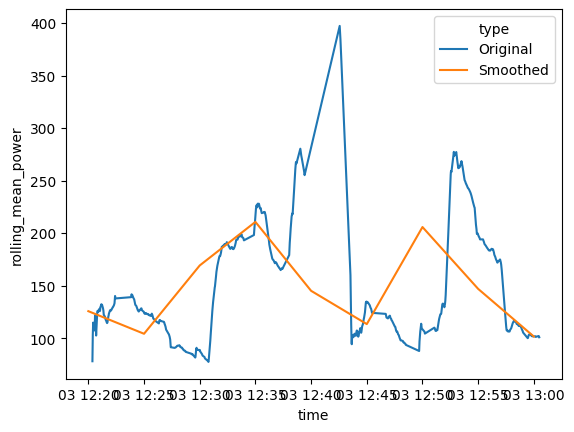

In [11]:
ride_name = 'NCVC_Segment_Challenge_2.gpx'
og_df = all_results[all_results['file_name'] == ride_name]
og_df['time'].dt.tz_localize('EST')
og_df['type'] = 'Original'
og_df['time'] = og_df['time'].dt.tz_localize('EST')

avg_df = results[results['ride'] == ride_name]
avg_df['type'] = 'Smoothed'
avg_df['time'] = avg_df.index

plot_df = pd.concat([og_df[['time','rolling_mean_power','type']],
                        avg_df[['time','rolling_mean_power','type']]])

sns.lineplot(x="time", y="rolling_mean_power",
            hue="type",
            data=plot_df)

/var/folders/y1/yg497znx1yx51vhnw3h2q_v1r7swj4/T/ipykernel_3958/418445187.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_df_hr['type'] = 'Smoothed Heart Rate'
/var/folders/y1/yg497znx1yx51vhnw3h2q_v1r7swj4/T/ipykernel_3958/418445187.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_df_hr['time'] = avg_df_hr.index
/var/folders/y1/yg497znx1yx51vhnw3h2q_v1r7swj4/T/ipykernel_3958/418445187.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

<Axes: xlabel='time', ylabel='value'>

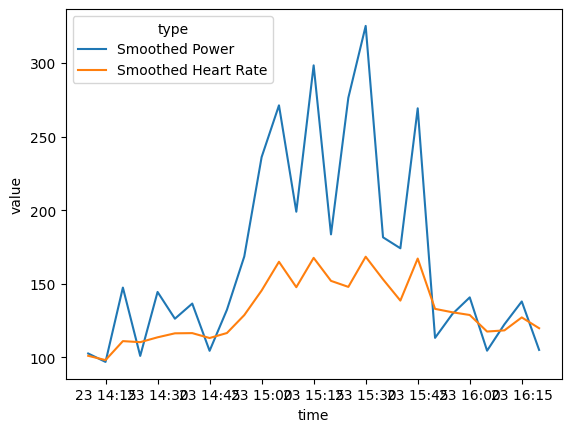

In [32]:
avg_df_hr = results[results['ride'] == 'Anacostia_Intervals_.gpx']
avg_df_hr['type'] = 'Smoothed Heart Rate'
avg_df_hr['time'] = avg_df_hr.index
avg_df_hr['value'] = avg_df_hr['rolling_mean_hr']

avg_df_pwr = results[results['ride'] == 'Anacostia_Intervals_.gpx']
avg_df_pwr['type'] = 'Smoothed Power'
avg_df_pwr['time'] = avg_df_pwr.index
avg_df_pwr['value'] = avg_df_pwr['rolling_mean_power']

plot_df = pd.concat([avg_df_pwr[['time','value','type']],
                        avg_df_hr[['time','value','type']]])

sns.lineplot(x="time", y="value",
            hue="type",
            data=plot_df)

In [36]:
training_data = pd.read_csv('data/training_data.csv')
training_data['date'] = pd.to_datetime(training_data['date'])

results['mins_since_start'] = results['time_since_start'].dt.total_seconds() / 60
results['rolling_mean_temp_freedom'] = (results['rolling_mean_temp'] * 1.8) + 32
results = results[results['mins_since_start'] < 300]

results['time'] = results.index
#results['time'] = results['time'].dt.tz_localize('EST')

results['date'] = pd.to_datetime(results['time']).dt.date

temp_results = results[results['date'] >= pd.to_datetime('2024-06-06')]
temp_results['date'] = pd.to_datetime(temp_results['date'])

temp_results = pd.merge(temp_results,training_data,on='date',how='left')

/Users/august.warren/opt/anaconda3/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/var/folders/y1/yg497znx1yx51vhnw3h2q_v1r7swj4/T/ipykernel_3958/2745981828.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_results['date'] = pd.to_datetime(temp_results['date'])


<Axes: xlabel='rolling_mean_hr', ylabel='rolling_mean_power'>

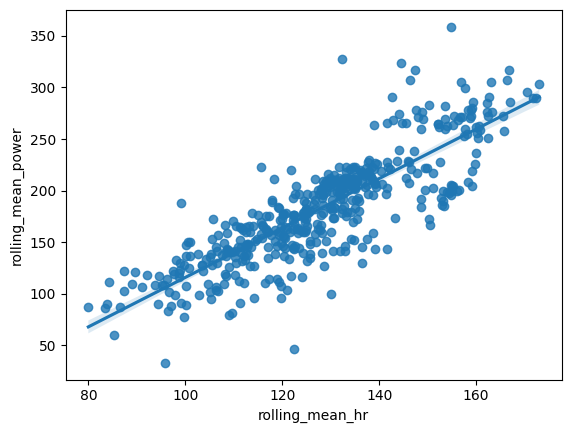

In [37]:
sns.regplot(x='rolling_mean_hr',y='rolling_mean_power',data=temp_results)

In [38]:
temp_results[temp_results['rolling_mean_power'] == temp_results['rolling_mean_power'].max()]

,latitude,longitude,rolling_mean_power,rolling_mean_hr,rolling_mean_cad,rolling_mean_temp,time_since_start,ride,time,date,mins_since_start,rolling_mean_temp_freedom,Fatigue,CTL
13,38.992159,-76.89395,358.807726,154.745927,78.936878,34.400334,0 days 01:35:00,Final_Greenbelt.gpx,2024-07-10 17:00:00-05:00,2024-07-10,95.0,93.920602,92.37265,77.0


In [39]:
example_df = temp_results.copy()

example_df['temp_bin'] = np.where(example_df['rolling_mean_temp_freedom'] >= 90,'>= 90 degrees','< 90 degrees')

display(example_df['temp_bin'].value_counts())

plot_df = example_df.groupby('temp_bin')[['rolling_mean_power','rolling_mean_hr']].mean()

plot_df = plot_df.reset_index().melt(id_vars='temp_bin')
plot_df['temp_bin'] = np.where(plot_df['temp_bin'] == '< 90 degrees', 'Less than 90°F','Greater than 90°F')
plot_df['variable'] = np.where(plot_df['variable'] == 'rolling_mean_power', 'Average Power','Average Heart Rate')

< 90 degrees     332
>= 90 degrees    145
Name: temp_bin, dtype: int64

/Users/august.warren/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


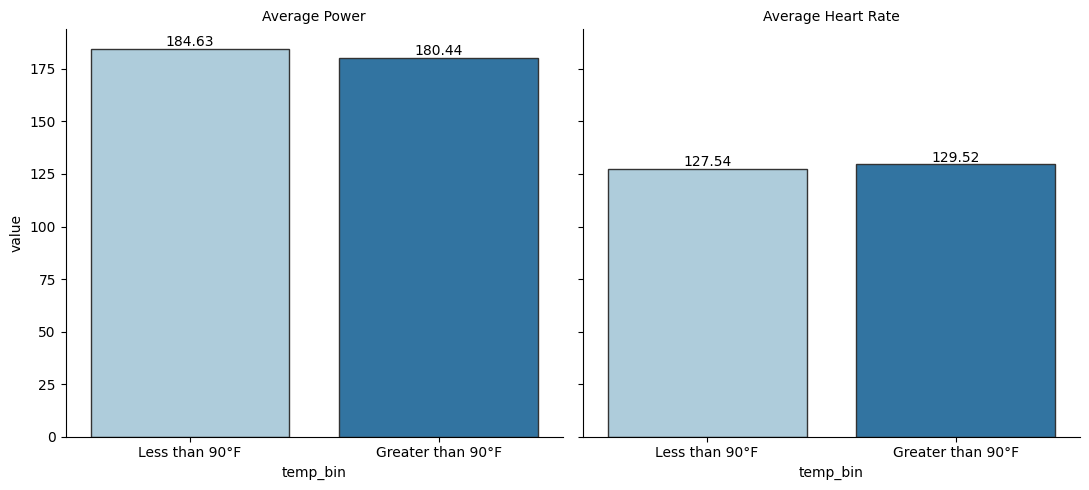

In [44]:
sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

g = sns.FacetGrid(plot_df, col="variable", hue="temp_bin", palette = "Paired",height=5, aspect= 1.1)
g.map(sns.barplot, "temp_bin", "value",edgecolor=".2")
g.set_titles(col_template="{col_name}", row_template="{row_name}")

for ax in g.axes.ravel():
    for p in ax.patches:
            ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

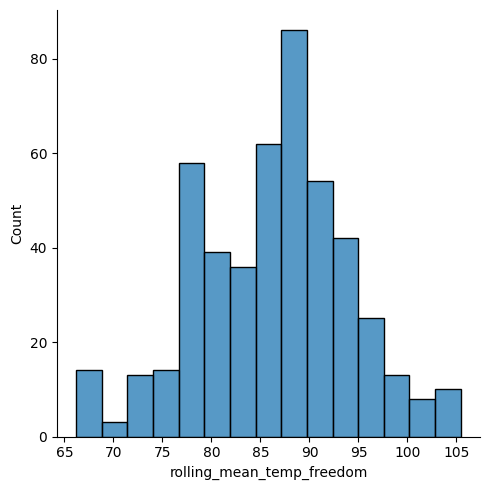

In [45]:
sns.displot(temp_results['rolling_mean_temp_freedom'])

In [153]:
results = sm.add_constant(temp_results)

reg_model = sm.OLS(temp_results['rolling_mean_power'], temp_results[['rolling_mean_hr',
                                                                        'rolling_mean_temp_freedom',
                                                                        'Fatigue']],data=temp_results).fit()

reg_model.summary()

/Users/august.warren/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['data']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     rolling_mean_power   R-squared (uncentered):                   0.982
Model:                            OLS   Adj. R-squared (uncentered):              0.982
Method:                 Least Squares   F-statistic:                              6704.
Date:                Wed, 17 Jul 2024   Prob (F-statistic):                   5.04e-322
Time:                        23:17:54   Log-Likelihood:                         -1737.9
No. Observations:                 373   AIC:                                      3482.
Df Residuals:                     370   BIC:                                      3494.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
rolling_mean_hr               2.4629      0.067     36.762      0.000       2.331       2.595
rolling_mean_temp_freedom    -1.3915      0.187     -7.444      0.000      -1.759      -1.024
Fatigue                      -0.0713      0.168     -0.424      0.672      -0.402       0.259
==============================================================================
Omnibus:                       63.051   Durbin-Watson:                   1.122
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              260.704
Skew:                           0.654   Prob(JB):                     2.45e-57
Kurtosis:                       6.881   Cond. No.                         32.9
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [141]:
np.corrcoef([results['rolling_mean_hr'],results['rolling_mean_power'],results['rolling_mean_temp_freedom'],results['Fatigue']])

array([[ 1.        ,  0.83902264,  0.04764356, -0.1605758 ],
       [ 0.83902264,  1.        , -0.06818317, -0.01826399],
       [ 0.04764356, -0.06818317,  1.        ,  0.46813486],
       [-0.1605758 , -0.01826399,  0.46813486,  1.        ]])